# Data Transformations before Modeling Process

Note: some of preliminary methodogy for merging datasets and cleaning to set up data for training/testing is taken from https://www.kaggle.com/code/raddar/vilnius-ncaa which is a submission from the Kaggle competition the code is taken from. We will be adding other external attributes (including Pomeroy rankings and Autodraft logic) and using a different modeling process

# Importing CSV files from Kaggle

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
os.getcwd()

'/Users/genachick/Desktop/data_mining_course_project'

In [2]:
regular_results = pd.read_csv("MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("MNCAATourneyDetailedResults.csv")
seeds = pd.read_csv("MNCAATourneySeeds.csv")
teams = pd.read_csv("MTeams.csv")

In [3]:
display(regular_results.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [4]:
# Ensuring earliest year in datasets is 2003 (Consistent with Pomeroy Rankings)
print(min(regular_results["Season"].value_counts().index))
print(min(tourney_results["Season"].value_counts().index))
seeds = seeds.loc[seeds["Season"] >= 2003]
print(min(seeds["Season"].value_counts().index))

2003
2003
2003


For visualization purposes: can see how a team performs over the course of its regular season and its tournament for each season. 

In [5]:
# let's take one random team and see its journey during the 2024 season
season = 2024
teamid = 1104

# showing regular season going into the tournament and tournament data for the year
r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/632077965.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/632077965.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/632077965.py:16: SettingWithCopyWarning: 
A value is trying to be set on 

,DayNum,WScore,LScore,type,win
107636,0,105,73,regular season,win
107805,4,102,80,regular season,win
107979,8,102,46,regular season,win
108100,11,98,67,regular season,win
108506,18,92,81,regular season,lose
108528,19,99,91,regular season,win
108655,22,85,77,regular season,lose
108930,28,89,65,regular season,win
109117,33,92,86,regular season,lose
109262,40,85,82,regular season,lose


In [6]:
# Looking into format of "seeds" table 
seeds.reset_index(drop=True, inplace=True)
s = seeds.loc[seeds["Season"] == 2003]
[s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]
# Note that X, Y, Z, W are the divisions and each will have its own seed. 

[    Season  Seed  TeamID
 16    2003   X01    1400
 17    2003   X02    1196
 18    2003   X03    1462
 19    2003   X04    1390
 20    2003   X05    1163
 21    2003   X06    1268
 22    2003   X07    1277
 23    2003   X08    1261
 24    2003   X09    1345
 25    2003   X10    1160
 26    2003   X11    1423
 27    2003   X12    1140
 28    2003   X13    1360
 29    2003   X14    1407
 30    2003   X15    1358
 31    2003  X16a    1411
 32    2003  X16b    1421,
     Season Seed  TeamID
 33    2003  Y01    1246
 34    2003  Y02    1338
 35    2003  Y03    1266
 36    2003  Y04    1173
 37    2003  Y05    1458
 38    2003  Y06    1281
 39    2003  Y07    1231
 40    2003  Y08    1332
 41    2003  Y09    1428
 42    2003  Y10    1104
 43    2003  Y11    1356
 44    2003  Y12    1451
 45    2003  Y13    1409
 46    2003  Y14    1221
 47    2003  Y15    1447
 48    2003  Y16    1237,
     Season Seed  TeamID
 49    2003  Z01    1112
 50    2003  Z02    1242
 51    2003  Z03    1181
 52  

# Double the dataset with swapped team positions in box scores
- Avoid bias from putting team in T1 position (on left vs. right)
- Help model generalize rather than learn teams specific position

In [7]:
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    # Swapping team positions
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    # if positive point diff (assuming team 1 is the winner or loser we consider), then team 1 wins
    output["win"] = (output["PointDiff"] > 0) * 1
    # output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/3766623745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot
/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/3766623745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot


In [8]:
display(regular_data.head())

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,...,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win
0,2003,10,1328,62.0,1104,68.0,0,22.0,53.0,2.0,...,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,6.0,1
1,2003,10,1393,63.0,1272,70.0,0,24.0,67.0,6.0,...,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,7.0,1
2,2003,11,1437,61.0,1266,73.0,0,22.0,73.0,3.0,...,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,12.0,1
3,2003,11,1457,50.0,1296,56.0,0,18.0,49.0,6.0,...,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,6.0,1
4,2003,11,1208,71.0,1400,77.0,0,24.0,62.0,6.0,...,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,6.0,1


# Want tourney data for **labels** to train on

In [9]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
display(massey.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
massey.dtypes

,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260


Season         int64
TeamID         int64
OrdinalRank    int64
dtype: object

In [10]:
# grabbing numeric part of seed and converting to int ( we still want to keep the division info)
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))
seeds["division"] = seeds["Seed"].apply(lambda x: x[0])

seeds_T1 = seeds[["Season", "TeamID", "seed","division"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed", "division"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed", "T1_division"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed", "T2_division"]

# merging seeds (for each team) with tourney data
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win",]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]

display(tourney_data)

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff
0,2003,1421,1411,7.111111,1,16,X,16,X,0
1,2003,1112,1436,29.000000,1,1,Z,16,Z,15
2,2003,1113,1272,13.000000,1,10,Z,7,Z,-3
3,2003,1141,1166,6.000000,1,11,Z,6,Z,-5
4,2003,1143,1301,1.777778,1,8,W,9,W,1
...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,4,Z,11,Z,7
2760,2024,1397,1345,-6.000000,0,2,Y,1,Y,-1
2761,2024,1104,1163,-14.000000,0,4,X,1,W,-3
2762,2024,1301,1345,-13.000000,0,11,Z,1,Y,-10


<Axes: xlabel='Seed_diff', ylabel='PointDiff'>

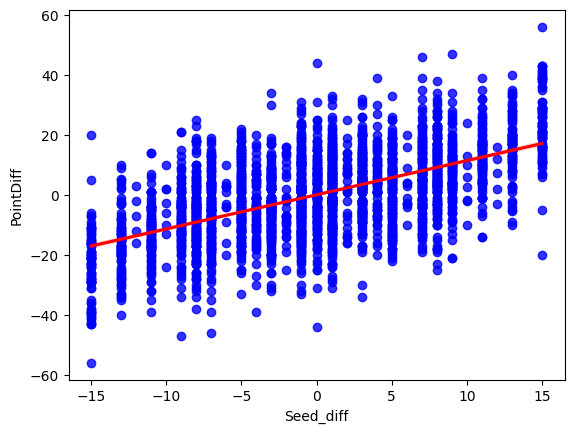

In [11]:
# seed difference vs point difference (between Team 1 and Team 2)
sns.regplot(x=tourney_data["Seed_diff"], y=tourney_data["PointDiff"], color='blue', line_kws={"color": "red"})

# Aggregating Game Stats: Offensive/Defensive for *Each T1 and T2*

In [12]:
# From MRegularSeasonDetailedResults and some of ourcalculations (point diff)
# box score columns, for which we want features to our model
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

# Regular season is **attributes** we train on

In [13]:
# calculate season averages for each team 
# for each team, we take the mean of the box score columns (for each unique instance of team T1 and year)
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

# merging season averages with tourney data
tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,...,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2003,1421,1411,7.111111,1,16,X,16,X,0,...,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148
1,2003,1112,1436,29.000000,1,1,Z,16,Z,15,...,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655
2,2003,1113,1272,13.000000,1,10,Z,7,Z,-3,...,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487
3,2003,1141,1166,6.000000,1,11,Z,6,Z,-5,...,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990
4,2003,1143,1301,1.777778,1,8,W,9,W,1,...,15.374074,21.129630,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370


In [14]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'T1_seed',
       'T1_division', 'T2_seed', 'T2_division', 'Seed_diff', 'T1_avg_Score',
       'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3', 'T1_avg_FGA3', 'T1_avg_FTM',
       'T1_avg_FTA', 'T1_avg_OR', 'T1_avg_DR', 'T1_avg_Ast', 'T1_avg_TO',
       'T1_avg_Stl', 'T1_avg_Blk', 'T1_avg_PF', 'T1_avg_opponent_Score',
       'T1_avg_opponent_FGM', 'T1_avg_opponent_FGA', 'T1_avg_opponent_FGM3',
       'T1_avg_opponent_FGA3', 'T1_avg_opponent_FTM', 'T1_avg_opponent_FTA',
       'T1_avg_opponent_OR', 'T1_avg_opponent_DR', 'T1_avg_opponent_Ast',
       'T1_avg_opponent_TO', 'T1_avg_opponent_Stl', 'T1_avg_opponent_Blk',
       'T1_avg_opponent_PF', 'T1_avg_PointDiff', 'T2_avg_Score', 'T2_avg_FGM',
       'T2_avg_FGA', 'T2_avg_FGM3', 'T2_avg_FGA3', 'T2_avg_FTM', 'T2_avg_FTA',
       'T2_avg_OR', 'T2_avg_DR', 'T2_avg_Ast', 'T2_avg_TO', 'T2_avg_Stl',
       'T2_avg_Blk', 'T2_avg_PF', 'T2_avg_opponent_Score',
       'T2_avg_opponent_FGM',

Basically, tourney schedule is deciding WHICH matchups we use in training set (and who won!), seeds, and point differences.
For each team in the match up, we are going to include its season averages in play statistics IN this row. This way, we are training on during-season data to see if we can predict tournament matchup results (our bracket)

# Questions: 
- Should we be subtracting or taking ratios between T1 and T2 stats so we can get relative stats? 
- Do we want ALL of these during game stats or do we just want certain ones? We can start with all and use some systematic feature selection because we don't have too much field knowledge

Note: to add: massey ordinals rankings (diff?), pomeroy ratings (diff?), conference 

In [15]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
display(massey.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
massey.dtypes


,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260


Season         int64
TeamID         int64
OrdinalRank    int64
dtype: object

From source: https://kenpom.com (also includes meaning for each field)

In [16]:
#test = pd.merge(tourney_data, massey, left_on=["Season", "T2_TeamID"], right_on=["Season", "TeamID"], how="left")

In [17]:
# We will be combining in this data from Pomeroy rankings (external source)
pomeroy = pd.read_csv("KenPom Stats.csv")
pomeroy = pomeroy.dropna()
pomeroy = pomeroy.drop(columns=[col for col in pomeroy.columns if "_rank" in col])
pomeroy["YEAR"] = pomeroy["YEAR"].astype(int)
# remove periods from team name column 
pomeroy['Team'] = pomeroy['Team'].str.replace('.', '', regex=False)
dat= pd.merge(pomeroy, teams[["TeamID", "TeamName"]], how='inner',left_on="Team", right_on="TeamName")
dat = dat.drop(columns=dat.columns[-1])

print(pomeroy["Team"].nunique())
print(dat["Team"].nunique())
display(dat)

# for this file we can use the ranking for each stat (its built in) and maybe use some differences
# because we also have the raw value for these statistics, idk which we would want

# mapping to this table's year and Team id (team id to team name table)

395
290


/var/folders/5f/5s29j0y5649fyd533yyz_8_w0000gn/T/ipykernel_64952/1074537758.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  pomeroy = pd.read_csv("KenPom Stats.csv")


,Rk,Team,Conf,W_L,NetRtg,ORtg,DRtg,AdjT,Luck,SchedStrengthNetRtg,SchedStrengthORtg,SchedStrengthDRtg,NCSOSNetRtg,YEAR,TeamID
0,1.0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1246
1,2.0,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,1242
2,3.0,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,1338
3,4.0,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1112
4,5.0,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,1228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,356.0,New Hampshire,AE,24-Aug,-21.72,93.9,115.6,67.6,0.019,-6.16,103.7,109.9,-3.50,2025,1306
6218,359.0,Canisius,MAAC,28-Mar,-23.01,99.1,122.1,66.4,-0.078,-4.88,103.0,107.9,3.86,2025,1145
6219,360.0,Alabama A&M,SWAC,22-Oct,-23.36,92.2,115.6,71.2,-0.022,-9.57,101.3,110.8,1.93,2025,1105
6220,361.0,Coppin St,MEAC,24-Jun,-24.40,87.4,111.8,68.0,0.033,-4.43,105.3,109.8,4.14,2025,1164


Note that with using pomeroy data we are gonna be reducing the number of teams, but these teams not considered likely won't be tournament games we care about. We can make that call

To do list

In [18]:
# add in the massey ordinals - NEED TO CHOOSE SYSTEM
# add in pomeroy rankings (delete all columns with rank because are showing what rank that team would be in terms of that stat)
# take all differences T1 - T2 for each stat
# can keep the point differences and win/loss columns (we can decide later when fitting models if we want numeric or binary label)
# export to csv 
# bring into weka - start looking at correlations of our final dataset 

In [19]:
# Merge pomeroy ORtg and DRtg for T1
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T1_ORtg',
    'DRtg': 'T1_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,7.111111,1,16,X,16,X,0,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29.000000,1,1,Z,16,Z,15,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13.000000,1,10,Z,7,Z,-3,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6.000000,1,11,Z,6,Z,-5,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,1.777778,1,8,W,9,W,1,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,4,Z,11,Z,7,...,8.370370,24.092593,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2
2760,2024,1397,1345,-6.000000,0,2,Y,1,Y,-1,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2
2761,2024,1104,1163,-14.000000,0,4,X,1,W,-3,...,7.588235,18.441176,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0
2762,2024,1301,1345,-13.000000,0,11,Z,1,Y,-10,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4


In [20]:
#tourney_data = tourney_data.iloc[:, :-8]
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,7.111111,1,16,X,16,X,0,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29.000000,1,1,Z,16,Z,15,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13.000000,1,10,Z,7,Z,-3,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6.000000,1,11,Z,6,Z,-5,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,1.777778,1,8,W,9,W,1,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,4,Z,11,Z,7,...,8.370370,24.092593,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2
2760,2024,1397,1345,-6.000000,0,2,Y,1,Y,-1,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2
2761,2024,1104,1163,-14.000000,0,4,X,1,W,-3,...,7.588235,18.441176,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0
2762,2024,1301,1345,-13.000000,0,11,Z,1,Y,-10,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4


In [21]:
# Merge pomeroy ORtg and DRtg for T2
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T2_ORtg',
    'DRtg': 'T2_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,...,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg
0,2003,1421,1411,7.111111,1,16,X,16,X,0,...,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN
1,2003,1112,1436,29.000000,1,1,Z,16,Z,15,...,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8,101.1,99.5
2,2003,1113,1272,13.000000,1,10,Z,7,Z,-3,...,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4,110.9,94.1
3,2003,1141,1166,6.000000,1,11,Z,6,Z,-5,...,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN,112.4,94.9
4,2003,1143,1301,1.777778,1,8,W,9,W,1,...,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3,111.2,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,4,Z,11,Z,7,...,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2,114.3,98.4
2760,2024,1397,1345,-6.000000,0,2,Y,1,Y,-1,...,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2,125.2,94.6
2761,2024,1104,1163,-14.000000,0,4,X,1,W,-3,...,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0,127.5,91.1
2762,2024,1301,1345,-13.000000,0,11,Z,1,Y,-10,...,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4,125.2,94.6


In [22]:
massey

,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260
...,...,...,...
1048570,2010,1403,35
1048571,2010,1404,307
1048572,2010,1405,300
1048573,2010,1406,275


In [23]:
# Merge massey ordinals for T1
tourney_data = tourney_data.merge(
    massey[['TeamID', 'Season', 'OrdinalRank']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'OrdinalRank': 'T1_OrdinalRank',
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,...,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg,T1_OrdinalRank
0,2003,1421,1411,7.111111,1,16,X,16,X,0,...,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,218.0
1,2003,1421,1411,7.111111,1,16,X,16,X,0,...,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,236.0
2,2003,1421,1411,7.111111,1,16,X,16,X,0,...,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,266.0
3,2003,1421,1411,7.111111,1,16,X,16,X,0,...,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,223.0
4,2003,1421,1411,7.111111,1,16,X,16,X,0,...,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426643,2024,1181,1301,-12.000000,0,4,Z,11,Z,7,...,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2,114.3,98.4,NaN
426644,2024,1397,1345,-6.000000,0,2,Y,1,Y,-1,...,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2,125.2,94.6,NaN
426645,2024,1104,1163,-14.000000,0,4,X,1,W,-3,...,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0,127.5,91.1,NaN
426646,2024,1301,1345,-13.000000,0,11,Z,1,Y,-10,...,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4,125.2,94.6,NaN
